# 02: Physics-Informed Neural Networks (PINNs)

**Exercise:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/02-pinn/02-pinn-exercise.ipynb)
**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/02-pinn/02-pinn.ipynb)

In [ ]:
# !pip3 install plotly nbformat --quiet

## Universal Approximation Theorem

Te Universal Approximation Theorem is a critical aspect of neural networks. It essentially states that a feedforward neural network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of $\mathbb{R}^n$ , under mild assumptions on the activation function. This property makes neural networks incredibly powerful tools for modeling an array of nonlinear systems.

A typical neural network consists of an input layer, one or more hidden layers, and an output layer. The neurons in these layers are connected by weighted links, and each connection has an associated weight that the network adjusts during the learning process.

Each neuron processes input, applies an activation function (like the sigmoid, tanh, or ReLU), and produces an output. The complexity of the functions that can be modeled by the network depends on the architecture, including the number of hidden layers and the number of neurons in each layer.

The Universal Approximation Theorem formally states that a neural network with just one hidden layer can approximate any continuous function to an arbitrary level of accuracy, given a sufficient (but finite) number of neurons in the hidden layer.

Let $\varphi: \mathbb{R} \rightarrow \mathbb{R}$ be a nonconstant, bounded, and continuous activation function. Consider a feedforward neural network mapping $\mathbb{R}^n$ to $\mathbb{R}^m$ with a single hidden layer containing $K$ hidden units. Let $w_{kj}$ denote the weight connecting the $j^{th}$ input to the $k^{th}$ hidden unit, $b_k$ the bias of the $k^{th}$ hidden unit, $v_{ik}$ the weight connecting the $k^{th}$ hidden unit to the $i^{th}$ output unit, and $c_i$ the bias of the $i^{th}$ output unit.

The function computed by the neural network can be expressed as:

$$f(x) = V\varphi(Wx + b) + c$$

Where $x \in \mathbb{R}^n$, $f(x) \in \mathbb{R}^m$, $W$ is a $K\times n$ matrix of weights $w_{kj}$, $b \in \mathbb{R}^K$ is the vector of hidden biases $b_k$, $V$ is an $m\times K$ matrix of weights $v_{ik}$, and $c \in \mathbb{R}^m$ is the vector of output biases $c_i$. The activation function $\varphi$ is applied element-wise to the hidden layer values $Wx + b$.

The universal approximation theorem states that if $\varphi$ is nonconstant, bounded, and continuous, then for any continuous function $g(x)$ defined on a compact subset of $\mathbb{R}^n$, and any $\epsilon > 0$, there exists a neural network $f(x)$ with parameters $W, b, V, c$ such that:

$$|f(x) - g(x)|_{\infty} < \epsilon \quad \forall x \in \mathbb{R}^n$$

for all $x$ in the compact set. In other words, the neural network can approximate the function $g(x)$ arbitrarily well, given enough hidden units.

The proof relies on the fact that finite linear combinations of activation functions can uniformly approximate any continuous function on a compact set, based on the [Weierstrass approximation theorem](https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem). Adding more hidden units increases the space of functions that can be represented by the neural network.

Although powerful, the universal approximation property doesn't guarantee an easy learning process. The theorem does not provide guidance on the optimal architecture, nor does it tell us anything about the learnability of the function. Training deep neural networks to approximate complex functions can still be a challenging task, requiring careful consideration of the architecture, learning algorithm, and hyperparameters.

# Data-driven NN

Given a set of discrete data, generated from $f(x, y) = \sin(x) \sin(y)$ over the domain $x, y \rightarrow [-\pi, \pi] \times [-\pi, \pi]$, we want to fit a surface, in the form of a neural network, to this dataset. A multi-layer neural network approximating the function $f$ can be constructed as $\hat{f} : (x, y) \mapsto \mathcal{N}_f(x, y; \mathbf{W}, \mathbf{b})$, with inputs $x, y$ and output $\hat{f}$.

Let's go ahead and create the dataset and visualize it:

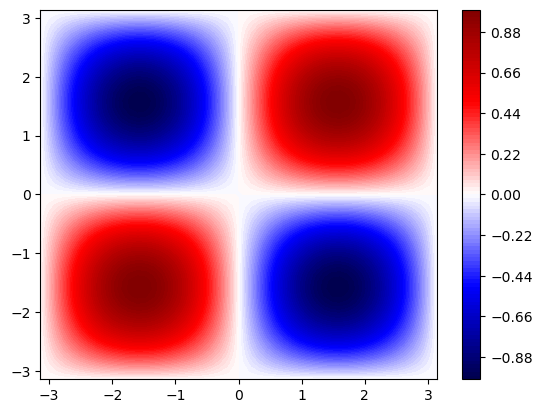

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Generate training data
x_data, y_data = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
f_data = np.sin(x_data) * np.sin(y_data)
x_data, y_data, f_data = torch.tensor(x_data.flatten()).float().view(-1, 1), torch.tensor(y_data.flatten()).float().view(-1, 1), torch.tensor(f_data.flatten()).float().view(-1, 1)

# plot training data in 2D with matplotlib as a contour plot
plt.contourf(x_data.view(50, 50), y_data.view(50, 50), f_data.view(50, 50), 100, cmap='seismic')
plt.colorbar()
plt.show()

We will use a four-layer NN with 10 neurons each and a hyperbolic-tangent activation function at each layer

In [2]:
class StandardNN(nn.Module):
    def __init__(self):
        super(StandardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Tanh(),
            nn.Linear(in_features=10, out_features=10),
            nn.Tanh(),
            nn.Linear(in_features=10, out_features=10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.layers(xy)


# Define model
model = StandardNN()

Once the networks are initialized, we set up the optimization problem and train the network by minimizing an objective function, i.e. solving the optimization problem for $W$ and $b$. The optimization problem for a data-driven curve-fitting is defined as:
$$
\text{arg min}_{W,b} \mathcal{L}(W, b) := \left\| f(x^*, y^*) - \mathcal{N}_f(x^*, y^*; W, b) \right\|
$$
where $x^*, y^*$ is the set of all discrete points where $f$ is given. For the loss-function $\left\| \circ \right\|$, we use the mean squared-error norm
$$
\left\| \circ \right\| = \frac{1}{N} \sum_{x^*, y^* \in I} \left( f(x^*, y^*) - \hat{f}(x^*, y^*) \right)^2.
$$


Data-driven model training progress:   0%|          | 0/5000 [00:00<?, ?it/s]

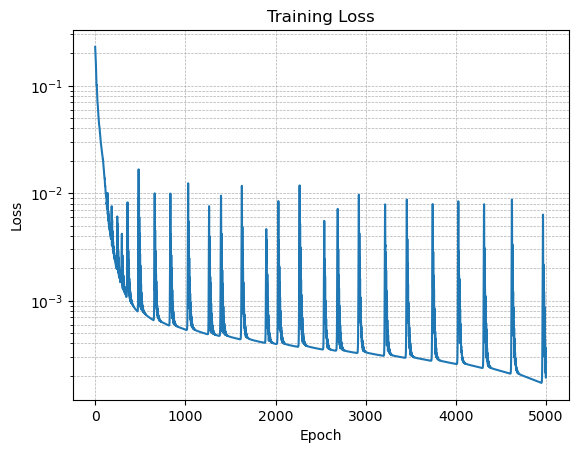

In [3]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

# Training loop
for epoch in tqdm(range(5000), desc='Data-driven model training progress'):
    optimizer.zero_grad()
    f_pred = model(x_data, y_data)
    loss = criterion(f_pred, f_data)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

# Plot the loss on a semilog scale
plt.figure()
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

> 💡 When the loss function is non-smooth like the one shown here, it means we are probably using a higher learning rate. Try reducing the learning rate to 0.005 and 0.001 to see the effect on the loss evolution

### Data-driven Neural Network implementation

Data-driven model training progress:   0%|          | 0/5000 [00:00<?, ?it/s]

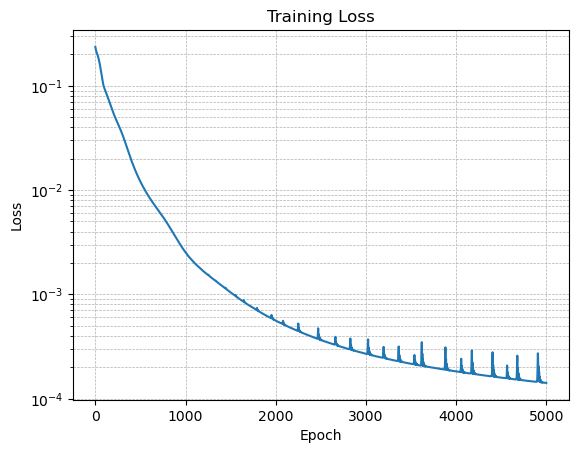

In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Define the standard neural network model
class StandardNN(nn.Module):
    def __init__(self):
        super(StandardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Tanh(),
            nn.Linear(in_features=10, out_features=10),
            nn.Tanh(),
            nn.Linear(in_features=10, out_features=10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.layers(xy)

# Generate training data
x_data, y_data = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
f_data = np.sin(x_data) * np.sin(y_data)
x_data, y_data, f_data = torch.tensor(x_data.flatten()).float().view(-1, 1), torch.tensor(y_data.flatten()).float().view(-1, 1), torch.tensor(f_data.flatten()).float().view(-1, 1)

# Define model
model = StandardNN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
for epoch in tqdm(range(5000), desc='Data-driven model training progress'):
    optimizer.zero_grad()
    f_pred = model(x_data, y_data)
    loss = criterion(f_pred, f_data)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

# Plot the loss on a semilog scale
plt.figure()
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

## Test the data-driven model

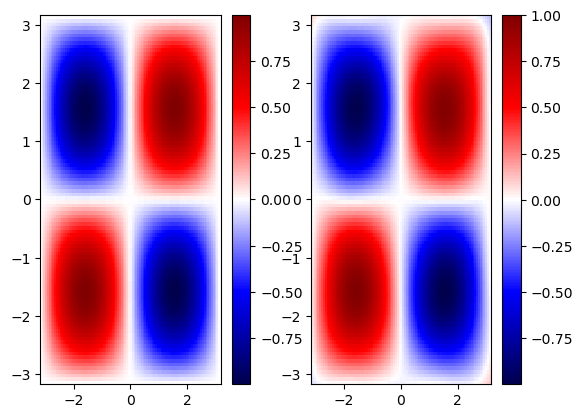

In [5]:
# Test the model
xyrange = 1 * np.pi
x_test, y_test = np.meshgrid(np.linspace(-xyrange, xyrange, 100), np.linspace(-xyrange, xyrange, 100))
f_test = np.sin(x_test) * np.sin(y_test)
x_test, y_test = torch.tensor(x_test).float().view(-1, 1), torch.tensor(y_test).float().view(-1, 1)
f_pred = model(x_test, y_test).detach().numpy().reshape(100, 100)

# Plotting
fig, ax = plt.subplots(1, 2)
im = ax[0].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])
im = ax[1].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])
plt.show()

### Plot error

In [6]:
import plotly.graph_objects as go

error = f_test - f_pred

fig = go.Figure(data=[go.Surface(z=error, x=x_test.numpy().reshape(100, 100), y=y_test.numpy().reshape(100, 100))])

fig.update_layout(title='Error between prediction and original data', 
                  autosize=False, width=800, height=700,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

### Extrapolate outside training range

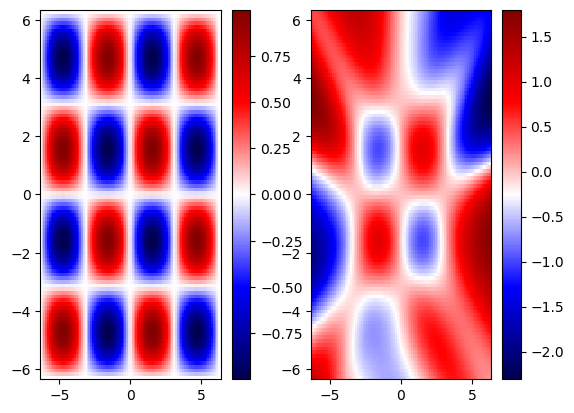

In [7]:
# Test the model
xyrange = 2 * np.pi
x_test, y_test = np.meshgrid(np.linspace(-xyrange, xyrange, 100), np.linspace(-xyrange, xyrange, 100))
f_test = np.sin(x_test) * np.sin(y_test)
x_test, y_test = torch.tensor(x_test).float().view(-1, 1), torch.tensor(y_test).float().view(-1, 1)
f_pred = model(x_test, y_test).detach().numpy().reshape(100, 100)

# Plotting
fig, ax = plt.subplots(1, 2)
im = ax[0].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])
im = ax[1].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])
plt.show()

We notice that the NN gave a reasonable approximation within the training ranges, however, when we extrapolate, we lose the predictive ability of NN. This is typical for most NN. Let's now explore how embedding physics in NN helps minimize the issue of lack of generalizability outside the training range.

# PINNs

Before diving into PINNs, it's worth briefly recalling the basic concept of a neural network. A neural network can be represented by a mathematical function $ f(\mathbf{x};\theta) $, where $ \mathbf{x} $ is the input, $ \theta $ is a set of parameters (weights and biases), and the output is obtained by composing linear transformations with non-linear activation functions through a sequence of layers.

The idea behind PINNs, introduced by [Raissi et al. (2017)](https://arxiv.org/pdf/1711.10561.pdf), is to enforce the neural network to satisfy some known physical laws or governing equations. This can be formulated by introducing a loss function that incorporates these physical constraints.

#### Loss Function

The total loss function for a PINN is typically a combination of a data loss term and a physics loss term:

$$\mathcal{L}(\theta) = \mathcal{L}_{data}(\theta) + \lambda \mathcal{L}_{physics}(\theta)$$

Here, $\lambda$ is a hyperparameter that balances the importance of data fidelity and physics consistency. The data loss term can be a standard mean squared error (MSE) that compares predictions with observed data:

$$\mathcal{L}_{data}(\theta) = \sum_{i=1}^{N} \| f(\mathbf{x}_i;\theta) - \hat{f}_i \|^2$$

The physics loss term enforces that the network's predictions satisfy the underlying physics, expressed as a partial differential equation (PDE) or other constraints:

$$
\mathcal{L}_{physics}(\theta) = \sum_{i=1}^{M} \| \mathcal{P}(f(\mathbf{x}_i';\theta), \nabla f(\mathbf{x}_i';\theta), \ldots) \|^2
$$

Here, $ \mathcal{P} $ is a differential operator representing the governing equations, and $ \nabla f(\mathbf{x}_i';\theta) $ denotes the gradients of the neural network with respect to its inputs, which can be computed using automatic differentiation.


PINNs offer several significant advantages:

- **Incorporating Prior Knowledge**: By embedding known physics into the training process, PINNs leverage domain expertise, often leading to more robust and interpretable models.
- **Data Efficiency**: By using physical constraints, PINNs can provide accurate predictions with fewer data points, mitigating the need for extensive data collection.
- **Solving PDEs**: PINNs can be applied to solve complex boundary value problems (BVPs) and initial value problems (IVPs) described by PDEs, without the need for traditional discretization methods.


![PINN](pinn.png)

> Schematic of a physics-informed neural network (PINN), where the loss function of PINN contains a mismatch in the given data on the state variables or boundary and initial conditions, i.e., $MSE_{u,BC,IC}$, and the residual for the PDE on a set of random points in the time-space domain, i.e., $MSE_R$. The hyperparameters of PINN can be learned by minimizing the total loss $MSE = MSE_{u,BC,IC} + MSE_R$.

## Computing Gradients with PyTorch

PyTorch provides automatic differentiation capabilities through the autograd package. This allows you to automatically compute gradients of tensors with respect to other tensors.

The `grad()` function computes the gradient of a tensor `f` with respect to a tensor `x`.

For example, let's compute the gradient of $f(x) = x^2$ at $x = 3$, which is $f^\prime(x) = 2 * x = 2 * 3 = 6$:

In [8]:
import torch

x = torch.tensor([3.], requires_grad=True)
f = x**2

f_x = torch.autograd.grad(f, x)[0]
print(f_x) # Output: tensor([6.])

tensor([6.])


This computes the gradient $df/dx$ at $x=3$, which is 6.

Some key things about `grad()`:

- The first argument is the tensor to compute gradients wrt (`f` in this case).
- The second argument is the tensor to take gradient of `(x)`.
- `grad()` returns a list of gradient tensors. For a single input, we take the first element `[0]`.

`create_graph=True`:

By default, `grad()` does not construct computational graphs for its backward pass. Setting `create_graph=True` forces it to construct the graphs, allowing you to take higher order derivatives.

For example let's compute the second derivative $f^{\prime\prime}(x) = 2$:

In [9]:
x = torch.tensor([3.], requires_grad=True)
f = x**2 
f_x = torch.autograd.grad(f, x, create_graph=True)[0] 

f_xx = torch.autograd.grad(f_x, x)[0]
print(f_xx) # Output: 2

tensor([2.])


## PINNs implementation

Continuing with fitting the data generated from $f (x, y) = \sin(x) \sin(y)$, we know that this is a solution
to $\nabla^2 f + 2f = 0$. We can implement a PINN. 

The Laplace equation is a second-order partial differential equation and is given by:

$$ \nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 0 $$

So, if you have $f(x,y) = \sin(x) \sin(y)$, you can plug it into the equation and calculate the second derivatives.

The second partial derivative with respect to $x$:

$$ \frac{\partial^2 f}{\partial x^2} = \frac{\partial}{\partial x} \left( \frac{\partial}{\partial x} \sin(x) \sin(y) \right) = \frac{\partial}{\partial x} \left( \cos(x) \sin(y) \right) = -\sin(x) \sin(y) $$

The second partial derivative with respect to $y$:

$$ \frac{\partial^2 f}{\partial y^2} = \frac{\partial}{\partial y} \left( \frac{\partial}{\partial y} \sin(x) \sin(y) \right) = \frac{\partial}{\partial y} \left( \sin(x) \cos(y) \right) = -\sin(x) \sin(y) $$

Putting it together, the Laplacian of $f$ is:

$$ \nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = -\sin(x) \sin(y) - \sin(x) \sin(y) = -2 \sin(x) \sin(y) $$

Therefore, $f(x,y) = \sin(x) \sin(y)$ is a solution to $\nabla^2 f + 2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} + 2 f = 0$

Based on the physics-informed deep learning framework, the governing equation can be imposed through the objective function. The loss function in the PDE space can then be defined as

$$\text{arg min}_{W,b} \mathcal{L}_{pde}(W, b) =  \left\| \nabla^2 \hat{f}(x^*, y^*) + 2 \hat{f}(x^*, y^*) \right\| = \left\| \frac{\partial^2 \hat{f}(x^*, y^*)}{\partial x^2} + \frac{\partial^2 \hat{f}(x^*, y^*)}{\partial y^2} + 2 \sin(x) \sin(y) \right\|$$

The loss function in the data space is: 

$$\text{arg min}_{W,b} \mathcal{L}_{data}(W, b) =  \left\|f(x, y) - \hat{f}(x^*, y^*)\right\|$$

The total loss function for PINN is:

$$\text{arg min}_{W,b} \mathcal{L} = \mathcal{L}_{data}  + \mathcal{L}_{pde} =  \left\|f(x, y) - \hat{f}(x^*, y^*)\right\| + \left\| \nabla^2 \hat{f}(x^*, y^*) + 2 \hat{f}(x^*, y^*) \right\| $$


Physics-informed model training progress:   0%|          | 0/5000 [00:00<?, ?it/s]

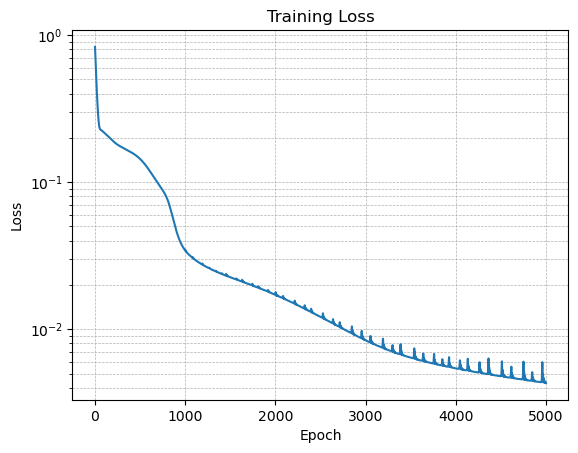

CPU times: user 3min 25s, sys: 1.54 s, total: 3min 27s
Wall time: 14.8 s


In [12]:
%%time

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.layers(xy)

    def loss_function(self, x, y):
        f = self.forward(x, y)
        f_x = torch.autograd.grad(f.sum(), x, create_graph=True)[0]
        f_xx = torch.autograd.grad(f_x.sum(), x, create_graph=True)[0]
        f_y = torch.autograd.grad(f.sum(), y, create_graph=True)[0]
        f_yy = torch.autograd.grad(f_y.sum(), y, create_graph=True)[0]

        pde_loss = f_xx + f_yy + 2 * f
        return torch.mean((f - torch.sin(x) * torch.sin(y))**2) + torch.mean(pde_loss**2)


# Generate training data
x_data, y_data = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
x_data, y_data = torch.tensor(x_data.flatten(), requires_grad=True).float().view(-1, 1), torch.tensor(y_data.flatten(), requires_grad=True).float().view(-1, 1)

# Define model
model = PINN()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
for pinn_epoch in tqdm(range(5000), desc='Physics-informed model training progress'):
    optimizer.zero_grad()
    loss = model.loss_function(x_data, y_data)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


# Plot the loss on a semilog scale
plt.figure()
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


## Test the PINN model

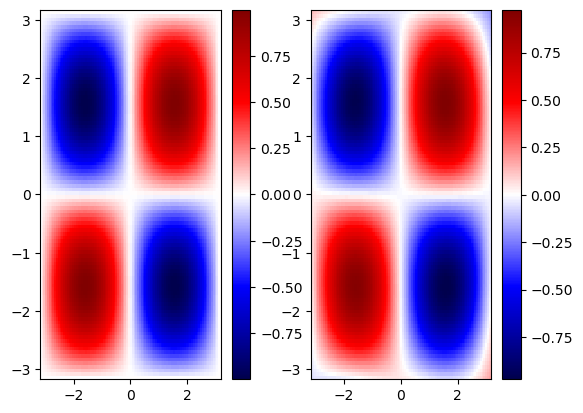

In [15]:
# Generate test data
xyrange = 1 * np.pi
x_test, y_test = np.meshgrid(np.linspace(-xyrange, xyrange, 100), np.linspace(-xyrange, xyrange, 100))
x_test, y_test = torch.tensor(x_test).float().view(-1, 1), torch.tensor(y_test).float().view(-1, 1)
f_test = (torch.sin(x_test) * torch.sin(y_test)).detach().numpy().reshape(100, 100)
f_pred = model(x_test, y_test).detach().numpy().reshape(100, 100)

# Plotting
fig, ax = plt.subplots(1, 2)
im = ax[0].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])
im = ax[1].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])
plt.show()

#### Error plot

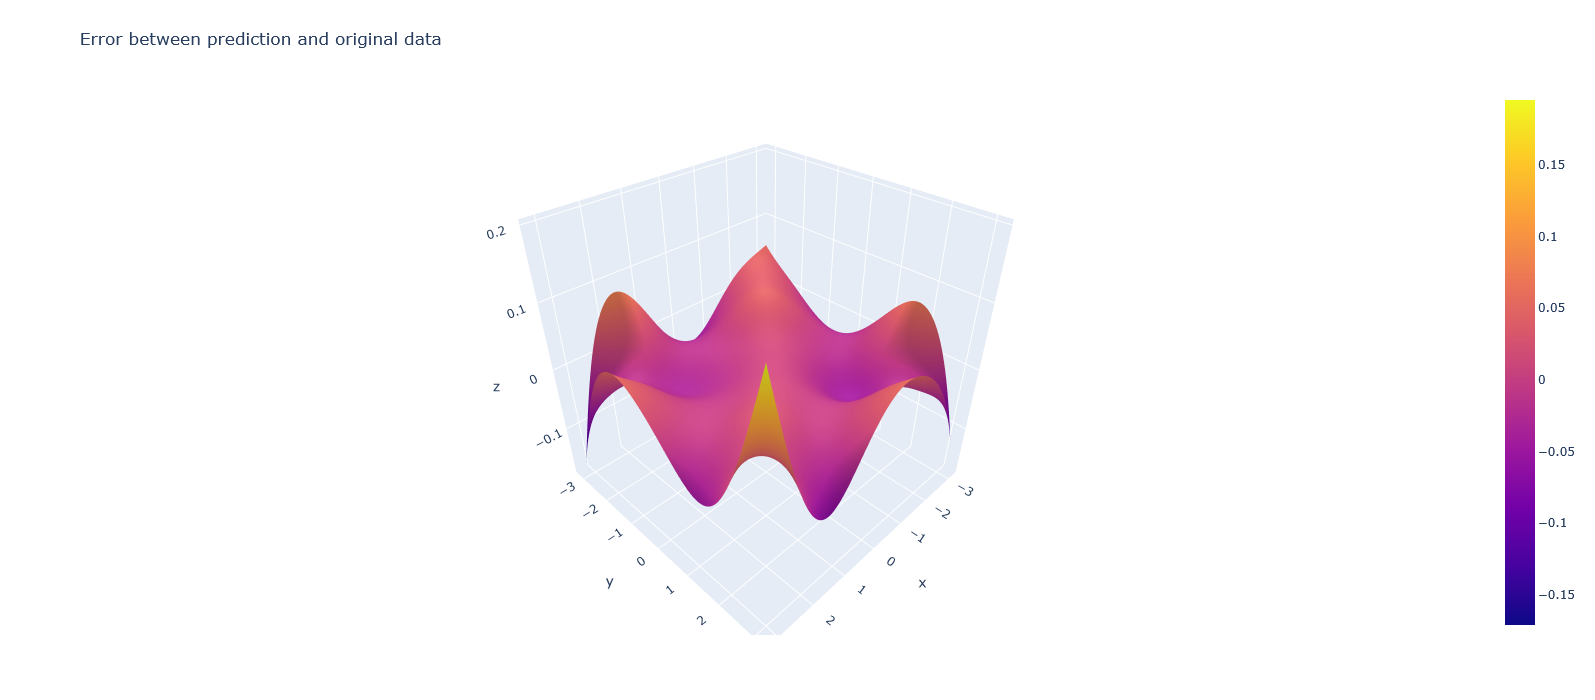

In [16]:
import plotly.graph_objects as go

error = f_test - f_pred

fig = go.Figure(data=[go.Surface(z=error, x=x_test.numpy().reshape(100, 100), y=y_test.numpy().reshape(100, 100))])

fig.update_layout(title='Error between prediction and original data', 
                  autosize=False, width=800, height=700,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

### Extrapolate outside training regime

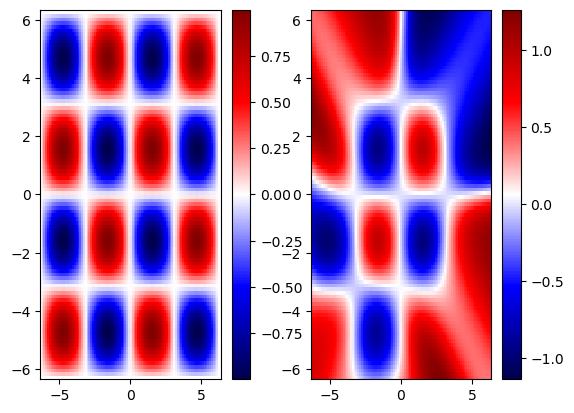

In [17]:
# Generate test data
xyrange = 2 * np.pi
x_test, y_test = np.meshgrid(np.linspace(-xyrange, xyrange, 100), np.linspace(-xyrange, xyrange, 100))
x_test, y_test = torch.tensor(x_test).float().view(-1, 1), torch.tensor(y_test).float().view(-1, 1)
f_test = (torch.sin(x_test) * torch.sin(y_test)).detach().numpy().reshape(100, 100)
f_pred = model(x_test, y_test).detach().numpy().reshape(100, 100)

# Plotting
fig, ax = plt.subplots(1, 2)
im = ax[0].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_test, cmap='seismic')
plt.colorbar(im, ax=ax[0])
im = ax[1].pcolor(x_test.numpy().reshape(100, 100), y_test.numpy().reshape(100, 100), f_pred, cmap='seismic')
plt.colorbar(im, ax=ax[1])
plt.show()

We notice that that PINN solution has better generalization than the pure data-driven solution. However, it still fails to generalize beyond the training regime. 

## Limitations of PINNs


1. **Hyperparameter Sensitivity**: The balance between the data loss term and the physics loss term is controlled by hyperparameters such as the weight $\lambda$. The choice of these hyperparameters can significantly affect the performance of the PINN, and finding the optimal values can be a delicate and challenging task.

2. **Complexity of Physical Equations**: When dealing with highly nonlinear or complex physical equations, the structure of the neural network and the training process may need to be carefully designed. This can make the application of PINNs more cumbersome and less generalizable.

3. **Computational Expense**: The additional loss terms related to the physical constraints might increase the computational cost of training, particularly if the equations involved are complex or require high-dimensional integrals to be solved.

4. **Lack of Robustness with Incomplete or Incorrect Physical Knowledge**: If the physics encoded in the loss function is only an approximation or is incorrect, the network might learn and propagate these inaccuracies. In this sense, the performance of a PINN is tied to the correctness and completeness of the physical laws being enforced.

5. **Challenges with Discontinuities**: Handling discontinuities in the solution or in the underlying physical properties can be challenging for PINNs. This is a common issue in many numerical methods for differential equations, and PINNs are not exempt from it.

6. **Limited Understanding of Theoretical Properties**: The integration of physical laws into neural networks is a relatively new area of study, and many theoretical aspects remain unexplored. This lack of understanding can lead to unexpected behavior and challenges in analyzing and proving properties of the trained models.

7. **Interpretability and Transparency**: Even though PINNs incorporate physical laws, the neural network's internal workings can still be seen as a "black box." Understanding exactly how the model is arriving at its conclusions might not be straightforward, especially for very deep or complex networks.

8. **Data Mismatch and Noise Sensitivity**: While PINNs are designed to work well with limited data, they can still be sensitive to the quality of the data used for training. If there is a mismatch between the data and the physics being enforced (e.g., due to measurement noise), this can lead to conflicts that might affect the training convergence and the quality of the solution.

9. **Training Data and Boundary Conditions Sensitivity**: PINNs trained for specific boundary conditions may not generalize well to different boundary conditions. The learned model might be highly tailored to the specific constraints and geometries used during training, limiting its applicability to other scenarios.

10. **Scalability Issues**: Applying PINNs to very large-scale problems might present challenges in terms of computational resources and efficiency. Training on high-dimensional inputs or over large domains might require substantial computational power and memory.

While PINNs provide a promising direction for integrating physics into machine learning models, they come with their own set of challenges and limitations. These should be carefully considered and addressed when applying PINNs to real-world problems. Further research and development are needed to mitigate these limitations and expand the applicability of PINNs in various domains.